# Caco-2 (Cell Effective Permeability) regression task

The human colon epithelial cancer cell line, Caco-2, is used as an in vitro model to simulate the human intestinal tissue.

In [1]:
%cd ..

c:\Users\abhik\Documents\ML_projetcs


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from rdkit import Chem
from rdkit.Chem import AllChem
from itertools import combinations
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error #ML stats
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import matplotlib.pyplot as plt

from tdc.single_pred import ADME

from utils import modelling_utils

C:\Users\abhik\AppData\Local\Temp\ipykernel_12224\2690803851.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = ADME(name = 'Caco2_Wang')
split = data.get_split()

Found local copy...
Loading...
Done!


In [4]:
data_df = data.get_data()
data_df.columns = ["Name","SMILES","caco2"]

In [5]:
data_df.head()

,Name,SMILES,caco2
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000
3,creatinine,CN1CC(=O)NC1=N,-5.935409
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000


## RdKit Molecular property as features

In [6]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

In [7]:
def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props

In [8]:
data_df['props'] = data_df.SMILES.apply(smi2props)

In [9]:
data_df.head()

,Name,SMILES,caco2,props
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000,"[290.079038168, 290.271, 6.0, 5.0, 1.0, 5.0, 6..."
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000,"[245.177964356, 245.36599999999999, 2.0, 1.0, ..."
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000,"[299.152143532, 299.3700000000001, 4.0, 1.0, 1..."
3,creatinine,CN1CC(=O)NC1=N,-5.935409,"[113.058911844, 113.11999999999999, 4.0, 2.0, ..."
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000,"[337.20417910400005, 337.46300000000014, 3.0, ..."


In [10]:
data_df[property_names] = data_df['props'].to_list()

In [11]:
data_df.head()

,Name,SMILES,caco2,props,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000,"[290.079038168, 290.271, 6.0, 5.0, 1.0, 5.0, 6...",290.079038,290.271,6.0,5.0,1.0,5.0,...,10.892875,6.368997,3.514868,3.514868,2.465958,-2.60,13.386159,4.746545,2.295403,3.025620
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000,"[245.177964356, 245.36599999999999, 2.0, 1.0, ...",245.177964,245.366,2.0,1.0,6.0,1.0,...,11.571021,6.370462,1.967401,1.967401,1.051316,-1.75,16.250000,11.727160,12.320175,10.587019
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000,"[299.152143532, 299.3700000000001, 4.0, 1.0, 1...",299.152144,299.370,4.0,1.0,1.0,1.0,...,12.951046,8.102094,6.354310,6.354310,5.388741,-1.52,12.968359,4.059868,1.277623,2.393174
3,creatinine,CN1CC(=O)NC1=N,-5.935409,"[113.058911844, 113.11999999999999, 4.0, 2.0, ...",113.058912,113.120,4.0,2.0,0.0,2.0,...,4.562569,2.294726,1.020319,1.020319,0.561486,-1.06,5.084092,1.467127,0.640744,0.932376
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000,"[337.20417910400005, 337.46300000000014, 3.0, ...",337.204179,337.463,3.0,1.0,0.0,1.0,...,15.216525,9.759733,8.665479,8.665479,7.136475,-1.53,15.703697,4.796471,1.792760,3.012893


In [12]:
data_df.drop(columns=['Name', "SMILES", "props"], inplace=True)

In [13]:
data_df.head()

,caco2,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,-6.220000,290.079038,290.271,6.0,5.0,1.0,5.0,6.0,21.0,35.0,...,10.892875,6.368997,3.514868,3.514868,2.465958,-2.60,13.386159,4.746545,2.295403,3.025620
1,-3.860000,245.177964,245.366,2.0,1.0,6.0,1.0,1.0,18.0,41.0,...,11.571021,6.370462,1.967401,1.967401,1.051316,-1.75,16.250000,11.727160,12.320175,10.587019
2,-4.090000,299.152144,299.370,4.0,1.0,1.0,1.0,4.0,22.0,43.0,...,12.951046,8.102094,6.354310,6.354310,5.388741,-1.52,12.968359,4.059868,1.277623,2.393174
3,-5.935409,113.058912,113.120,4.0,2.0,0.0,2.0,2.0,8.0,15.0,...,4.562569,2.294726,1.020319,1.020319,0.561486,-1.06,5.084092,1.467127,0.640744,0.932376
4,-4.840000,337.204179,337.463,3.0,1.0,0.0,1.0,3.0,25.0,52.0,...,15.216525,9.759733,8.665479,8.665479,7.136475,-1.53,15.703697,4.796471,1.792760,3.012893


<AxesSubplot:ylabel='Frequency'>

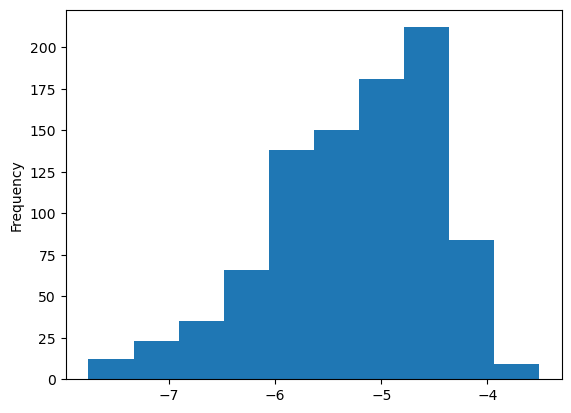

In [14]:
data_df["caco2"].plot.hist()

In [15]:
data_df.skew()

caco2                             -0.665807
exactmw                            0.438935
amw                                0.438580
lipinskiHBA                        0.555319
lipinskiHBD                        1.371120
NumRotatableBonds                  0.732091
NumHBD                             1.589697
NumHBA                             1.243191
NumHeavyAtoms                      0.462008
NumAtoms                           0.664681
NumHeteroatoms                     0.308065
NumAmideBonds                      1.569561
FractionCSP3                       0.250348
NumRings                           0.415160
NumAromaticRings                   0.032492
NumAliphaticRings                  1.395386
NumSaturatedRings                  1.530959
NumHeterocycles                    0.729057
NumAromaticHeterocycles            1.075119
NumSaturatedHeterocycles           1.279912
NumAliphaticHeterocycles           1.318858
NumSpiroAtoms                      6.772723
NumBridgeheadAtoms              

## Feature engineering and train test splitting

In [16]:
X = data_df.drop(columns=["caco2"])

In [17]:
pipeline = Pipeline(
        [
            ("scaling", StandardScaler()),
        ]
    )
X = pipeline.fit_transform(X)


In [18]:
y = data_df["caco2"]

## Hyperparaeter tuning anfd finding the best model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(
X_test, y_test, test_size=0.3, random_state=1)

rf_regressor = RandomForestRegressor()  # Baseline model
rf_regressor.fit(X_train, y_train)
y_hat = rf_regressor.predict(X_train)
y_val_hat = rf_regressor.predict(X_val)
y_test_hat = rf_regressor.predict(X_test)
print(f"Baseline model training loss : {root_mean_squared_error(y_train, y_hat)}")
print(f"Baseline model validation loss : {root_mean_squared_error(y_val, y_val_hat)}")
print(f"Baseline model test loss : {root_mean_squared_error(y_test, y_test_hat)}")

Baseline model training loss : 0.1606123563172868
Baseline model validation loss : 0.4431692541982043
Baseline model test loss : 0.41498398607048825


In [20]:
models = ["DecisionTreeRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "SVR"]

results = modelling_utils.evaluate_all_models(models, "hyperparameter_json_files/regression_hyperparameters.json",
                                                  X_train, y_train, X_val, y_val,
                                                  scoring_metric=root_mean_squared_error, task_type="regression")
print(f"Best model, validation rmse and parameters : {modelling_utils.find_best_model(results)}")

best_model_dict = modelling_utils.find_best_model(results)
best_model = modelling_utils.load_model(best_model_dict[0], "regression")
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(f"Best model test set rmse : {root_mean_squared_error(y_test, y_pred)}")
print(f"Best model test set r2 score : {r2_score(y_test, y_pred)}")
print(f"Best model test set mse : {mean_squared_error(y_test, y_pred)}")

Best model, validation rmse and parameters : ('GradientBoostingRegressor', 0.4258037199605269, {'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 500})
Best model test set rmse : 0.4177580499841159
Best model test set r2 score : 0.6600704055935178
Best model test set mse : 0.1745217883265311


## Visualising the performance of the regression model

[Text(0, 0.5, 'predicted')]

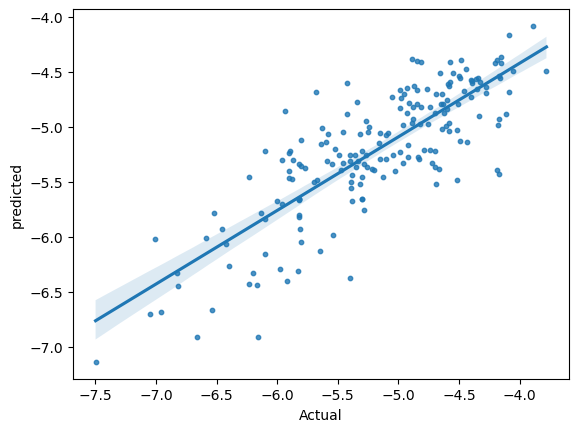

In [21]:
ax = sns.regplot(x=y_test,y=y_test_hat,scatter_kws={'s':10})
ax.set(xlabel="Actual")
ax.set(ylabel="predicted")

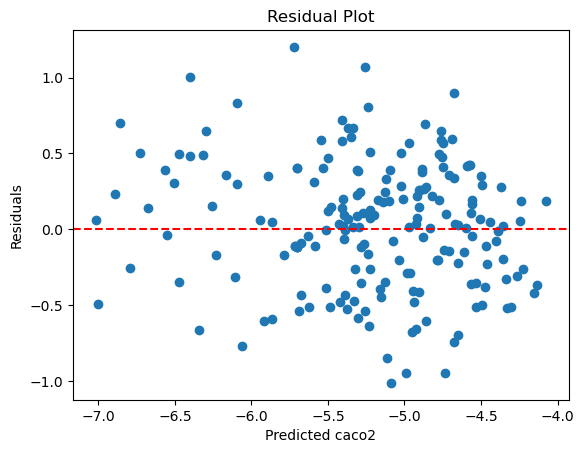

In [22]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted caco2')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()